In [1]:
import networkx as nx
import numpy as np
import pandas as pd

# for the explode statement; convert string to list
from ast import literal_eval

In [2]:
# for visualization
from IPython.display import SVG 
from sknetwork.visualization import svg_graph 
from sknetwork.data import Bunch 
from sknetwork.ranking import PageRank 
from scipy.sparse import csr_matrix

def draw_graph(G, show_names=False, node_size=1, font_size=10, edge_width=0.5):

    adjacency = nx.to_scipy_sparse_array(G, nodelist=None, dtype=None, weight='weight', format='csr')
    adjacency = csr_matrix(adjacency) # fix to weird sknetwork-csr issue; comment out to troubleshoot
    
    names = np.array(list(G.nodes))
    
    graph = Bunch()
    graph.adjacency = adjacency
    graph.names = np.array(names)
    
    pagerank = PageRank()
    scores = pagerank.fit_transform(adjacency)

    if show_names:
        
        image = svg_graph(graph.adjacency, font_size=font_size, node_size=node_size, names=graph.names, width=700, height=500, scores=scores, edge_width=edge_width)
    
    else:
        
        image = svg_graph(graph.adjacency, node_size=node_size, width=700, height=500, scores = scores, edge_width=edge_width)
    
    return SVG(image)

# Create Graph using Bipartite Projection on Arxiv Dataset

In [3]:
data = 'data/arxiv_artificial_life.csv'

df = pd.read_csv(data)
df['authors'] = df['authors'].apply(literal_eval)

df = df[['authors', 'title']]
df = df.explode('authors')
df.reset_index(drop=True, inplace=True)

# fix the & so that scikit-network stops crashing
df['authors'] = df['authors'].str.replace('&', 'and')
df['title'] = df['title'].str.replace('&', 'and')

df.head()

,authors,title
0,Zhenyu Mao,Multi-role Consensus through LLMs Discussions ...
1,Jialong Li,Multi-role Consensus through LLMs Discussions ...
2,Munan Li,Multi-role Consensus through LLMs Discussions ...
3,Kenji Tei,Multi-role Consensus through LLMs Discussions ...
4,Harrison B. Smith,An Agnostic Biosignature Based on Modeling Pan...


In [4]:
len(set(df['title']))

2000

In [5]:
from networkx.algorithms import bipartite

B = nx.from_pandas_edgelist(df, source='authors', target='title')
G = bipartite.projected_graph(B, df['authors'])

G = nx.k_core(G, 2) # no isolates or two-node groups

In [6]:
print(G)

Graph with 5520 nodes and 16119 edges


# Community Detection + Community Analysis

There's two parts to what I am attempting today.
- I need to use community detection to identify communities in the network.
- I can then use network science and data science to identify interesting communities

By interesting, I mean not stars. I am looking for complex ecosystems. So, I will identify communities, then attempt to detect more complex ecosystems by using triangles and density.

## Community Detection

In [7]:
import community as community_louvain

partition = community_louvain.best_partition(G, resolution=1, random_state=1337) # 10 was good for this network

In [8]:
community_df = pd.DataFrame().from_dict(partition, orient='index')
community_df.reset_index(inplace=True)
community_df.columns = ['node', 'community']

community_df['community'].value_counts()[0:20]

community
31     87
131    62
61     51
89     44
281    39
38     38
326    38
134    38
150    36
672    34
59     30
737    30
668    30
100    28
105    26
195    24
81     24
97     23
519    23
263    21
Name: count, dtype: int64

In [9]:
community_node_counts = community_df['community'].value_counts()

community_size_df = pd.DataFrame(community_node_counts).reset_index()
community_size_df.columns = ['community', 'node_count']

# just to speed up this experiment
community_size_df = community_size_df[community_size_df['node_count'] > 10]

community_size_df.head()

,community,node_count
0,31,87
1,131,62
2,61,51
3,89,44
4,281,39


In [10]:
community_size_df.shape

(76, 2)

## Capture Community Context

In [11]:
community_df.head()

,node,community
0,Zhenyu Mao,0
1,Jialong Li,0
2,Munan Li,0
3,Kenji Tei,0
4,Harrison B. Smith,2


In [12]:
community_size_df.head(1)

,community,node_count
0,31,87


In [13]:
def get_community_nodes(community_df, community):

    return sorted(community_df[community_df['community']==community]['node'].values)

In [14]:
def get_community_context(community_size_df, community_df, G):

    G = G.copy()

    communities = {}

    for row in community_size_df.iterrows():

        data = row[1]
        community = data['community']
        node_count = data['node_count']
        
        nodes = get_community_nodes(community_df, community)
        G_sub = G.subgraph(nodes)

        # starting with density today; will add on more context later
        density = nx.density(G_sub)
        
        communities[community] = {}

        communities[community]['G'] = G_sub
        communities[community]['density'] = density
        communities[community]['node_count'] = len(G_sub.nodes)
        
    return communities

In [15]:
community_context_dict = get_community_context(community_size_df, community_df, G)

In [16]:
community_context_df = pd.DataFrame(community_context_dict).T.reset_index()
community_context_df.columns = ['community', 'G', 'density', 'node_count']

community_context_df.head()

,community,G,density,node_count
0,31,"(Christoph Adami, Ashok Khanna, Thomas Pierrot...",0.387597,87
1,131,"(Sergio Greco, Krysia Broda, Angelika Kimmig, ...",0.123744,62
2,61,"(Naram Mhaisen, Wenbo Wang, Muhammad Umar Janj...",0.138039,51
3,89,"(Zahra Dasht Bozorgi, Fatemeh Akoochekian, Mar...",0.135307,44
4,281,"(Marcel van Gerven, Baihan Lin, Keerthiram Mur...",0.174089,39


<Axes: ylabel='Frequency'>

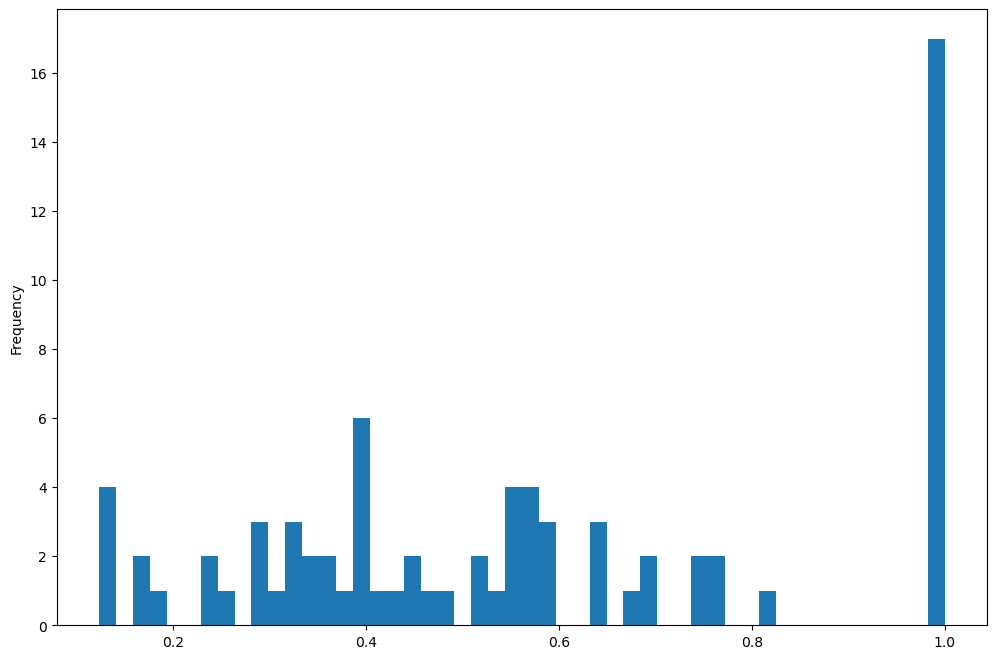

In [17]:
community_context_df['density'].plot.hist(bins=50, figsize=(12,8))

#### Investigate Communities

In [18]:
def show_author_papers(df, G):
    
    G = G.copy()
    
    check_nodes = G.nodes

    return sorted(df[df['authors'].isin(check_nodes)]['title'].unique())

In [19]:
def fetch_communities(community_context_df, min_density, max_density, max_nodes=None, n_communities=10):
    
    if max_nodes==None:
        community_context_df['node_count'].sum()
    
    community_context_df = community_context_df.copy()

    mask = (community_context_df['density']>min_density) \
        & (community_context_df['density']<max_density)  \
        & (community_context_df['node_count']<max_nodes)
    
    community_context_df = community_context_df[mask].copy()
    community_context_df = community_context_df.sample(n_communities) # grabbing ten to see the ranges

    community_context_df.sort_values('density', inplace=True)
    communities = community_context_df['community'].values[0:n_communities]
    
    return communities

In [20]:
def draw_community(G_check):

    print('Density: {}'.format(nx.density(G_check)))
    print('Node Count: {}'.format(len(G_check.nodes)))
    return draw_graph(G_check, show_names=True, node_size=3, edge_width=0.2)

In [37]:
min_density = 0.1
max_density = 0.3
max_nodes = 100

# .1 to .3 has more papers and more variation
# .3 to .6 is very cool
# .6 to .8 is cool to describe smaller more densely connected groups

# i did several iterations to find titles; sparse communities seem to have more and more interesting papers (opinion)

communities = fetch_communities(community_context_df, min_density=min_density, max_density=max_density, max_nodes=max_nodes, n_communities=10)
communities

array([131, 737,  61, 281, 672, 100, 195,   2, 879, 418], dtype=int64)

Density: 0.12374405076679006
Node Count: 62


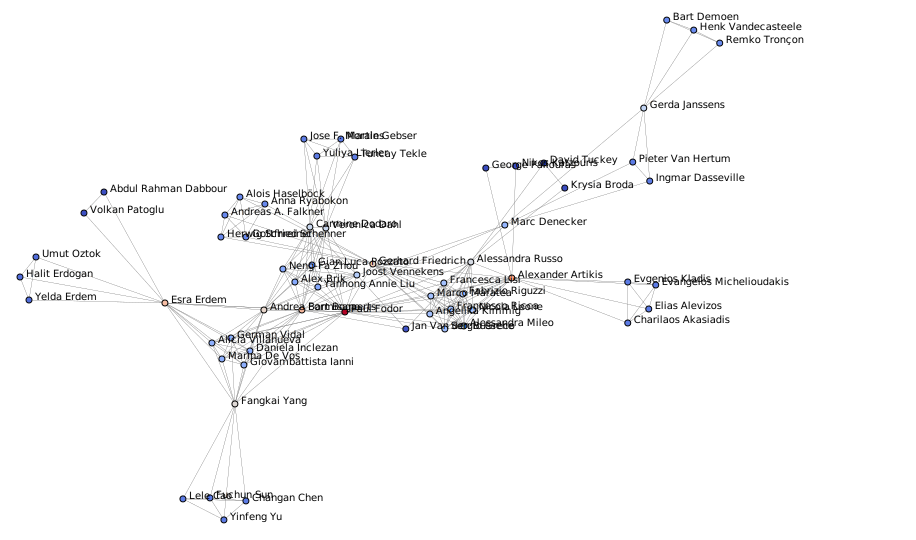

In [38]:
G_check = community_context_dict[communities[0]]['G']
draw_community(G_check)

In [39]:
show_author_papers(df, G_check)

#Efficient Top-k Ego-Betweenness Search
#Fast Algorithms for Intimate-Core Group Search in Weighted Graphs
#Fine-Grained Emotion Classification of Chinese Microblogs Based on Graph Convolution Networks
#Mining Bursting Communities in Temporal Graphs

['(Re)configuration based on model generation',
 'A general framework for scientifically inspired explanations in AI',
 'Early Time-Series Classification Algorithms: An Empirical Comparison',
 'FO(C): A Knowledge Representation Language of Causality',
 'Fast Frequent Querying with Lazy Control Flow Compilation',
 'Incremental Learning of Event Definitions with Inductive Logic Programming',
 'Measuring Acoustics with Collaborative Multiple Agents',
 'Object Placement on Cluttered Surfaces: A Nested Local Search Approach',
 'Problife: a Probabilistic Game of Life',
 'Proceedings 35th International Conference on Logic Programming (Technical Communications)',
 'Proceedings 36th International Conference on Logic Programming (Technical Communications)',
 'Proceedings 37th International Conference on Logic Programming (Technical Communications)',
 'Proceedings 38th International Conference on Logic Programming',
 'Querying Biomedical Ontologies in Natural Language using Answer Set',
 'The KB 

Density: 0.12873563218390804
Node Count: 30


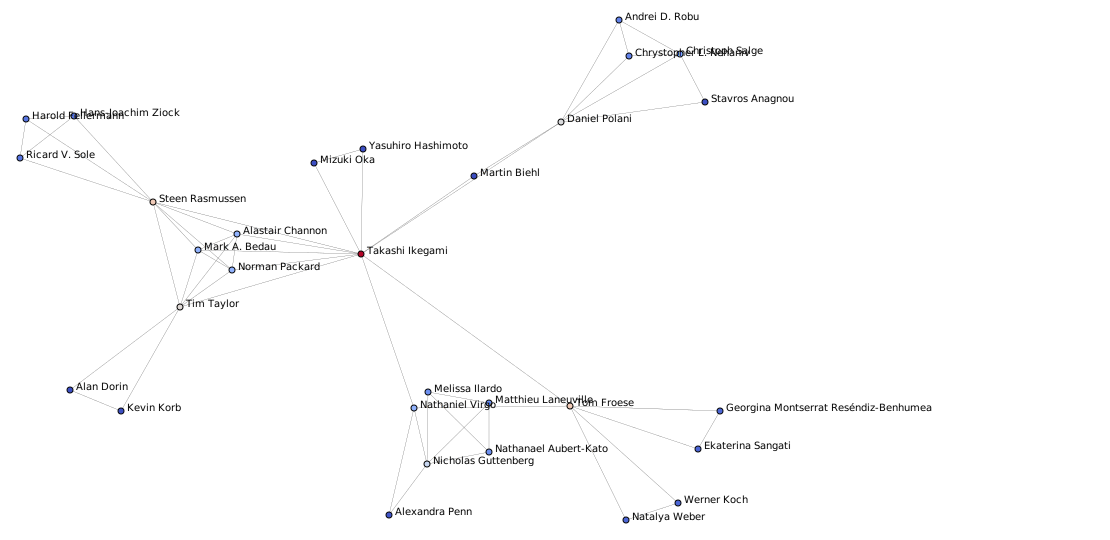

In [40]:
G_check = community_context_dict[communities[1]]['G']
draw_community(G_check)

In [41]:
show_author_papers(df, G_check)

#A Deep Learning Approach for Multimodal Deception Detection
#GraphTMT: Unsupervised Graph-based Topic Modeling from Video Transcripts
#RP-DNN: A Tweet level propagation context based deep neural networks for early rumor detection in Social Media
#Capturing Topology in Graph Pattern Matching
#Graph Pattern Matching for Dynamic Team Formation
#SceneRec: Scene-Based Graph Neural Networks for Recommender Systems

['Action and perception for spatiotemporal patterns',
 'An Overview of Open-Ended Evolution: Editorial Introduction to the Open-Ended Evolution II Special Issue',
 'An informational study of the evolution of codes and of emerging concepts in populations of agents',
 'Artificial Life and the Web: WebAL Comes of Age',
 'Changing the Environment based on Intrinsic Motivation',
 'Digital Genesis: Computers, Evolution and Artificial Life',
 'Evolutionary Innovations and Where to Find Them: Routes to Open-Ended Evolution in Natural and Artificial Systems',
 'Informational parasites in code evolution',
 'Levels of Coupling in Dyadic Interaction: An Analysis of Neural and Behavioral Complexity',
 'Life cycle of a minimal protocell - a dissipative particle dynamics (DPD) study',
 'Measuring Time with Minimal Clocks',
 'Motility at the origin of life: Its characterization and a model',
 'On the potential for open-endedness in neural networks',
 'Open-ended Evolution and a Mechanism of Novelties 

Density: 0.1380392156862745
Node Count: 51


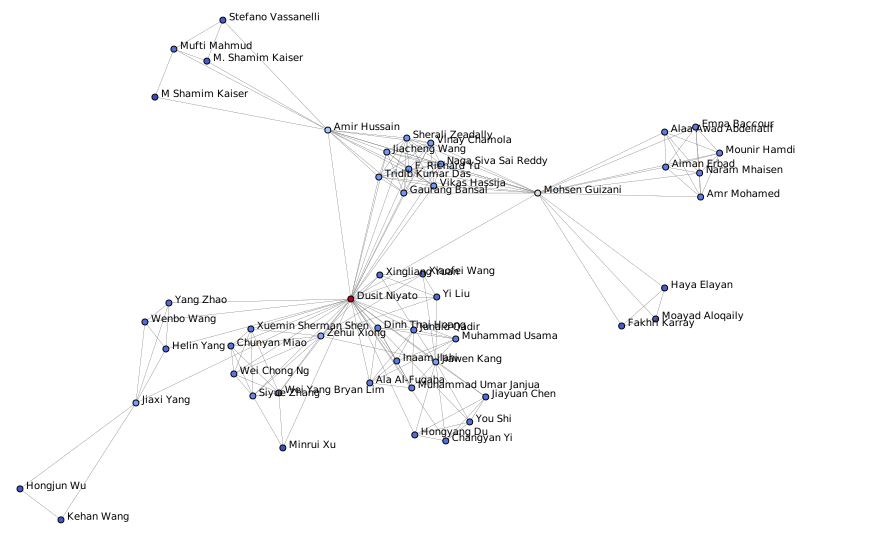

In [42]:
G_check = community_context_dict[communities[2]]['G']
draw_community(G_check)

In [43]:
show_author_papers(df, G_check)

#A Survey of Neural Trojan Attacks and Defenses in Deep Learning
#Physical world assistive signals for deep neural network classifiers -- neither defense nor attack
#PRAT: PRofiling Adversarial aTtacks
#Four hot DOGs in the microwave
#Outlyingness: why do outliers lie out?

['A Survey of Toxic Comment Classification Methods',
 'Agent-based computing from multi-agent systems to agent-based Models: a visual survey',
 'Applications of Deep Learning and Reinforcement Learning to Biological Data',
 'Beyond Reality: The Pivotal Role of Generative AI in the Metaverse',
 'Challenges and Countermeasures for Adversarial Attacks on Deep Reinforcement Learning',
 'Deep Learning in Mining Biological Data',
 'Federated Learning for 6G Communications: Challenges, Methods, and Future Directions',
 'Generative AI-Driven Human Digital Twin in IoT-Healthcare: A Comprehensive Survey',
 'Internet of Behavior (IoB) and Explainable AI Systems for Influencing IoT Behavior',
 'Pervasive AI for IoT applications: A Survey on Resource-efficient Distributed Artificial Intelligence',
 'Sustainable AIGC Workload Scheduling of Geo-Distributed Data Centers: A Multi-Agent Reinforcement Learning Approach',
 'Towards Green Metaverse Networking Technologies, Advancements and Future Direction

Density: 0.17408906882591094
Node Count: 39


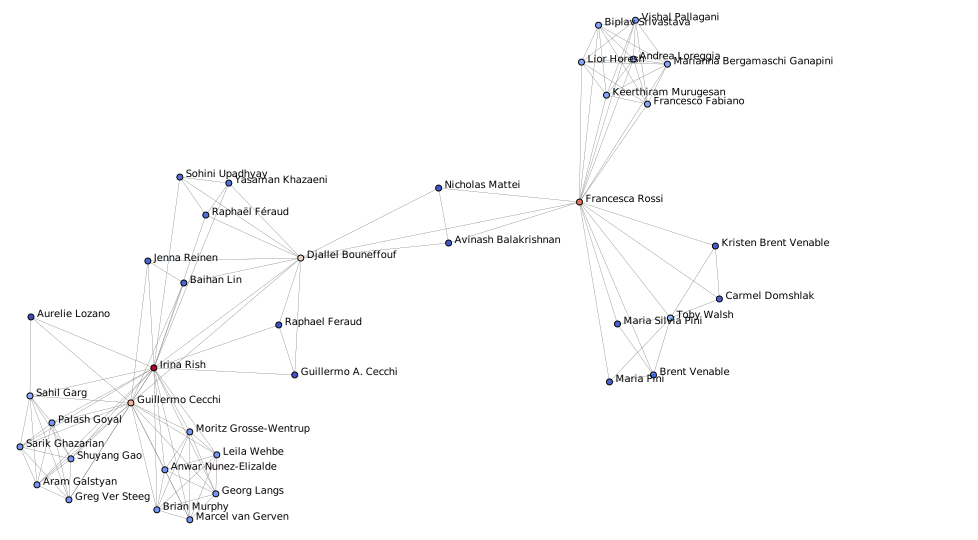

In [44]:
G_check = community_context_dict[communities[3]]['G']
draw_community(G_check)

In [45]:
show_author_papers(df, G_check)

#Natural Backdoor Attack on Text Data

['A Survey on Compositional Generalization in Applications',
 'Building Ethically Bounded AI',
 'Comprehensive Multi-Agent Epistemic Planning',
 'Context Attentive Bandits: Contextual Bandit with Restricted Context',
 'Contextual Bandit with Missing Rewards',
 "Dealing with incomplete agents' preferences and an uncertain agenda in group decision making via sequential majority voting",
 'Double-Linear Thompson Sampling for Context-Attentive Bandits',
 "Etat de l'art sur l'application des bandits multi-bras",
 'Fast and Slow Planning',
 'Incorporating Behavioral Constraints in Online AI Systems',
 'Modeling Psychotherapy Dialogues with Kernelized Hashcode Representations: A Nonparametric Information-Theoretic Approach',
 'NIPS 2016 Workshop on Representation Learning in Artificial and Biological Neural Networks (MLINI 2016)',
 'Neurogenesis-Inspired Dictionary Learning: Online Model Adaption in a Changing World',
 'Online Semi-Supervised Learning in Contextual Bandits with Episodic Rewar

Density: 0.1746880570409982
Node Count: 34


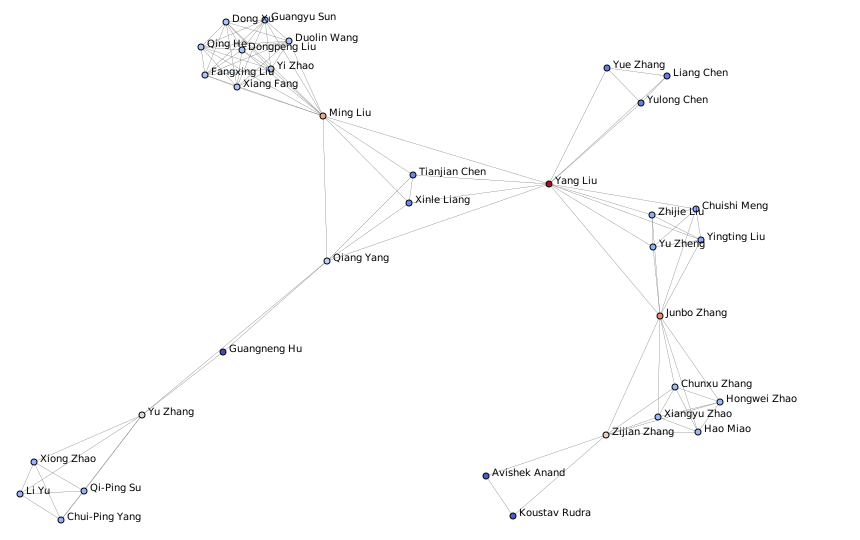

In [46]:
G_check = community_context_dict[communities[4]]['G']
draw_community(G_check)

In [47]:
show_author_papers(df, G_check)

#Entropy and the Predictability of Online Life

['AutoSTL: Automated Spatio-Temporal Multi-Task Learning',
 'Deep Learning Detection of Inaccurate Smart Electricity Meters: A Case Study',
 'DialogSum: A Real-Life Scenario Dialogue Summarization Dataset',
 'FaxPlainAC: A Fact-Checking Tool Based on EXPLAINable Models with HumAn Correction in the Loop',
 'Federated Forest',
 'Federated Transfer Reinforcement Learning for Autonomous Driving',
 'Transfer Meets Hybrid: A Synthetic Approach for Cross-Domain Collaborative Filtering with Text',
 'Universal controlled-phase gate with cat-state qubits in circuit QED']

Density: 0.1931216931216931
Node Count: 28


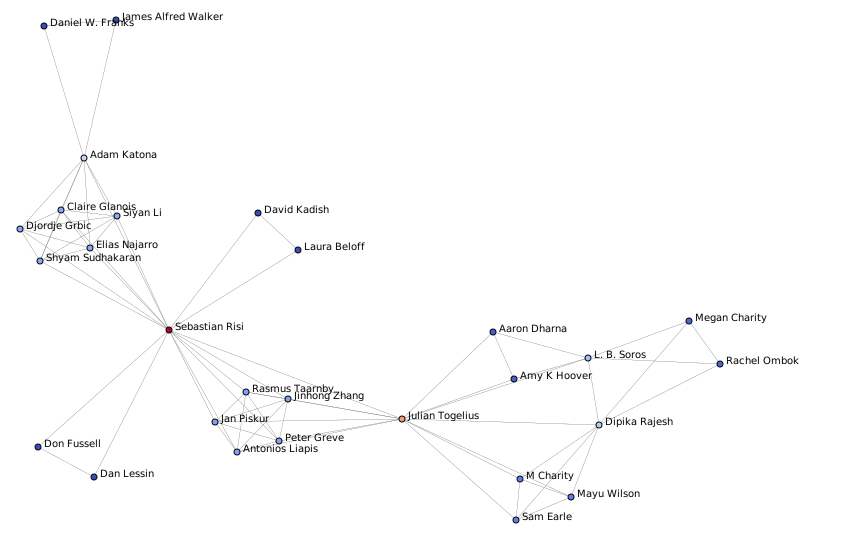

In [48]:
G_check = community_context_dict[communities[5]]['G']
draw_community(G_check)

In [49]:
show_author_papers(df, G_check)

#XENON1T Anomaly and its Implication for Decaying Warm Dark Matter
#Wandering in Color-Space -- why the life of pentaquark is so long ? --
#What can we learn from universal Turing machines?

['Amorphous Fortress: Observing Emergent Behavior in Multi-Agent FSMs',
 'An artifcial life approach to studying niche differentiation in soundscape ecology',
 'Co-generation of game levels and game-playing agents',
 'Growing 3D Artefacts and Functional Machines with Neural Cellular Automata',
 'Increasing Behavioral Complexity for Evolved Virtual Creatures with the ESP Method',
 'Quality Diversity in the Amorphous Fortress (QD-AF): Evolving for Complexity in 0-Player Games',
 'Quality Evolvability ES: Evolving Individuals With a Distribution of Well Performing and Diverse Offspring',
 'Say "Sul Sul!" to SimSim, A Sims-Inspired Platform for Sandbox Game AI',
 'The Case for a Mixed-Initiative Collaborative Neuroevolution Approach',
 'Transfer Dynamics in Emergent Evolutionary Curricula']

Density: 0.2391304347826087
Node Count: 24


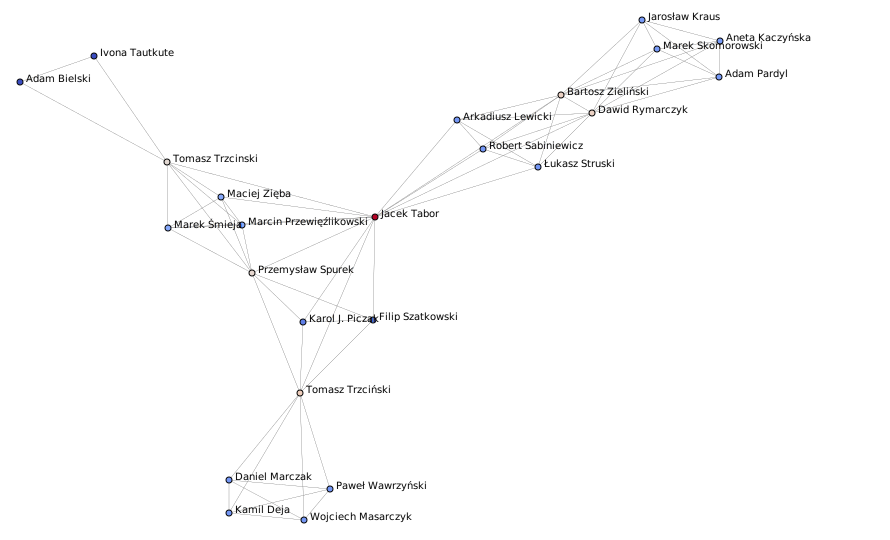

In [50]:
G_check = community_context_dict[communities[6]]['G']
draw_community(G_check)

In [51]:
show_author_papers(df, G_check)

#Causal Explanation Analysis on Social Media
#Overcoming Catastrophic Forgetting in Massively Multilingual Continual Learnin
#The Remarkable Benefit of User-Level Aggregation for Lexical-based Population-Level Predictions
#G-networks and the optimization of supply chains
#Lady and the Tramp Nextdoor: Online Manifestations of Economic Inequalities in the Nextdoor Social Network

['Hypernetworks build Implicit Neural Representations of Sounds',
 'I Know How You Feel: Emotion Recognition with Facial Landmarks',
 'Multiband VAE: Latent Space Alignment for Knowledge Consolidation in Continual Learning',
 'ProMIL: Probabilistic Multiple Instance Learning for Medical Imaging',
 'ProtoMIL: Multiple Instance Learning with Prototypical Parts for Whole-Slide Image Classification',
 'RegFlow: Probabilistic Flow-based Regression for Future Prediction']

Density: 0.24166666666666667
Node Count: 16


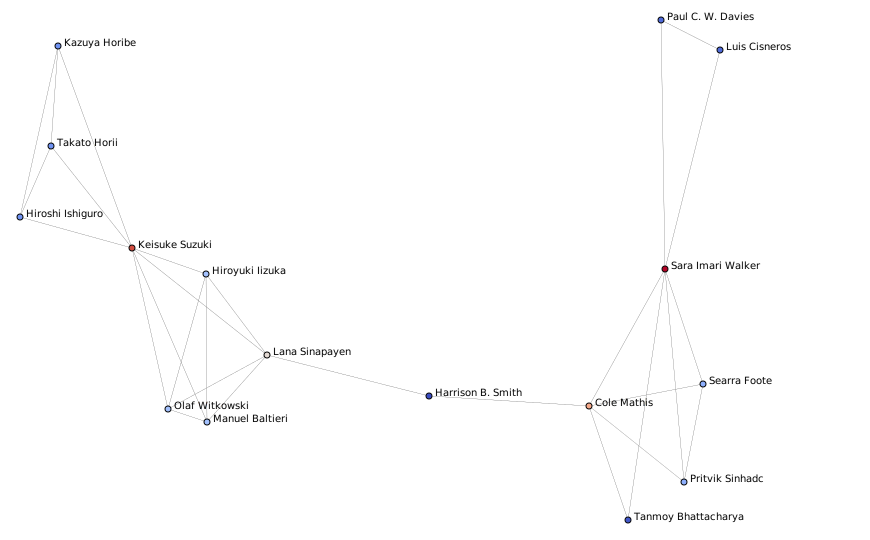

In [52]:
G_check = community_context_dict[communities[7]]['G']
draw_community(G_check)

In [53]:
show_author_papers(df, G_check)

#Real-Time Bidding by Reinforcement Learning in Display Advertising
#Ease-of-Teaching and Language Structure from Emergent Communication
#The Hanabi Challenge: A New Frontier for AI Research

['An Agnostic Biosignature Based on Modeling Panspermia and Terraformation',
 'An active inference implementation of phototaxis',
 "DNN Architecture for High Performance Prediction on Natural Videos Loses Submodule's Ability to Learn Discrete-World Dataset",
 'Evolutionary Generation of Visual Motion Illusions',
 'Evolutionary Transitions and Top-Down Causation',
 'Exploring the Adaptive Behaviors of Particle Lenia: A Perturbation-Response Analysis for Computational Agency',
 'False positives and the challenge of testing the alien hypothesis',
 'Hybrid Life: Integrating Biological, Artificial, and Cognitive Systems',
 "Life's Chirality From Prebiotic Environments",
 'Perspective: Purposeful Failure in Artificial Life and Artificial Intelligence',
 'The Chirality Of Life: From Phase Transitions To Astrobiology',
 'The Emergence of Life as a First Order Phase Transition',
 'The Futility of Exoplanet Biosignatures',
 'The modularity of action and perception revisited using control theory 

Density: 0.2878787878787879
Node Count: 12


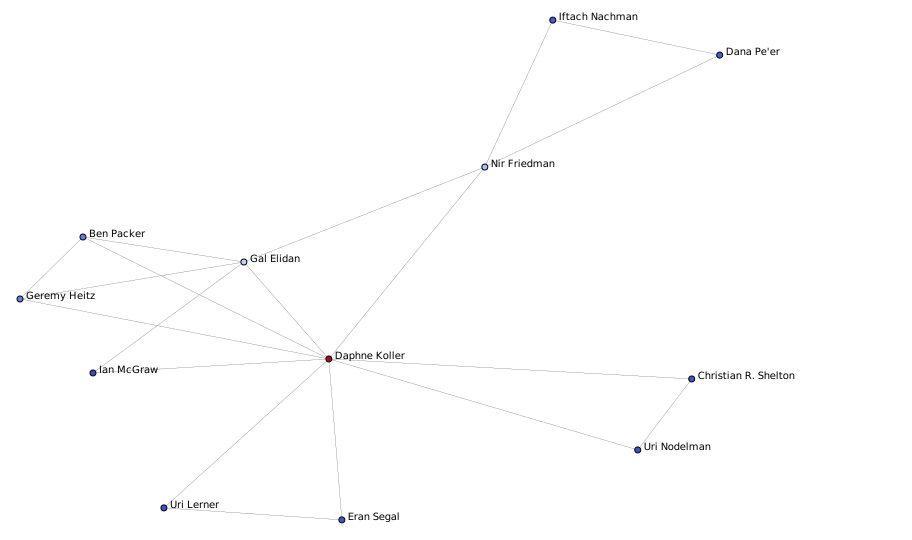

In [54]:
G_check = community_context_dict[communities[8]]['G']
draw_community(G_check)

In [55]:
show_author_papers(df, G_check)

#Large Graph Models: A Perspective

['Being Bayesian about Network Structure',
 'Convex Point Estimation using Undirected Bayesian Transfer Hierarchies',
 'Exact Inference in Networks with Discrete Children of Continuous Parents',
 'Expectation Maximization and Complex Duration Distributions for Continuous Time Bayesian Networks',
 'Gaussian Process Networks',
 'Learning Bayesian Network Structure from Massive Datasets: The "Sparse Candidate" Algorithm',
 'Learning the Dimensionality of Hidden Variables',
 'Residual Belief Propagation: Informed Scheduling for Asynchronous Message Passing',
 'Speedy Model Selection (SMS) for Copula Models',
 'The Information Bottleneck EM Algorithm']

Density: 0.29523809523809524
Node Count: 15


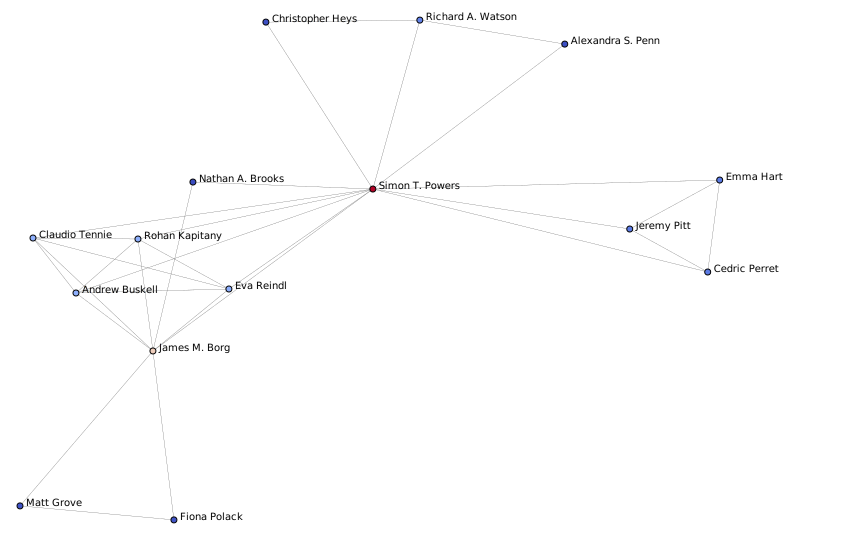

In [56]:
G_check = community_context_dict[communities[9]]['G']
draw_community(G_check)

In [57]:
show_author_papers(df, G_check)

#Does the evolution of complex life depend on the stellar spectral energy distribution?
#Funding the Search for Extraterrestrial Intelligence with a Lottery Bond
#Why do we find ourselves around a yellow star instead of a red star?
#Find the Conversation Killers: a Predictive Study of Thread-ending Posts -- HELL YES

['A mechanism to promote social behaviour in household load balancing',
 'Can justice be fair when it is blind? How social network structures can promote or prevent the evolution of despotism',
 'Coloured noise time series as appropriate models for environmental variation in artificial evolutionary systems',
 'Evolved Open-Endedness in Cultural Evolution: A New Dimension in Open-Ended Evolution Research',
 'How to measure group selection in real-world populations',
 'The efficacy of group selection is increased by coexistence dynamics within groups']

# Get Papers of Interest

In a separate text file, I add the papers I am interested in reading. I can then copy and paste them here, and do a quick 'split' to convert it into a useful list, which I can use to get URLs from the original DataFrame. 

In [59]:
papers = """
Efficient Top-k Ego-Betweenness Search
Fast Algorithms for Intimate-Core Group Search in Weighted Graphs
Fine-Grained Emotion Classification of Chinese Microblogs Based on Graph Convolution Networks
Mining Bursting Communities in Temporal Graphs
A Deep Learning Approach for Multimodal Deception Detection
GraphTMT: Unsupervised Graph-based Topic Modeling from Video Transcripts
RP-DNN: A Tweet level propagation context based deep neural networks for early rumor detection in Social Media
Capturing Topology in Graph Pattern Matching
Graph Pattern Matching for Dynamic Team Formation
SceneRec: Scene-Based Graph Neural Networks for Recommender Systems
A Survey of Neural Trojan Attacks and Defenses in Deep Learning
Physical world assistive signals for deep neural network classifiers -- neither defense nor attack
PRAT: PRofiling Adversarial aTtacks
Four hot DOGs in the microwave
Outlyingness: why do outliers lie out?
Natural Backdoor Attack on Text Data
Entropy and the Predictability of Online Life
XENON1T Anomaly and its Implication for Decaying Warm Dark Matter
Wandering in Color-Space -- why the life of pentaquark is so long ? --
What can we learn from universal Turing machines?
Causal Explanation Analysis on Social Media
Overcoming Catastrophic Forgetting in Massively Multilingual Continual Learnin
The Remarkable Benefit of User-Level Aggregation for Lexical-based Population-Level Predictions
G-networks and the optimization of supply chains
Lady and the Tramp Nextdoor: Online Manifestations of Economic Inequalities in the Nextdoor Social Network
Real-Time Bidding by Reinforcement Learning in Display Advertising
Ease-of-Teaching and Language Structure from Emergent Communication
The Hanabi Challenge: A New Frontier for AI Research
Large Graph Models: A Perspective
Does the evolution of complex life depend on the stellar spectral energy distribution?
Funding the Search for Extraterrestrial Intelligence with a Lottery Bond
Why do we find ourselves around a yellow star instead of a red star?
Find the Conversation Killers: a Predictive Study of Thread-ending Posts
SCB-dataset: A Dataset for Detecting Student Classroom Behavior
SCB-Dataset3: A Benchmark for Detecting Student Classroom Behavior
Did life originate from low-temperature areas of the Universe?
BEAMERS: Brain-Engaged, Active Music-based Emotion Regulation System
Human-Like Intuitive Behavior and Reasoning Biases Emerged in Language Models -- and Disappeared in GPT-4
Local Causal Structure Learning and its Discovery Between Type 2 Diabetes and Bone Mineral Density
Machine Psychology: Investigating Emergent Capabilities and Behavior in Large Language Models Using Psychological Methods
SINGA-Easy: An Easy-to-Use Framework for MultiModal Analysis
Secure Artificial Intelligence of Things for Implicit Group Recommendations
Thinking Fast and Slow in Large Language Models
Cultures in Community Question Answering
On the Behaviour of Deviant Communities in Online Social Networks
Uncovering Bias in Personal Informatics
Computational Metacognition
Large Language Models for User Interest Journeys
A Survey on Personality-Aware Recommendation Systems
MES-P: an Emotional Tonal Speech Dataset in Mandarin Chinese with Distal and Proximal Labels
Can Requirements Engineering Support Explainable Artificial Intelligence? Towards a User-Centric Approach for Explainability Requirements
AutoHEnsGNN: Winning Solution to AutoGraph Challenge for KDD Cup 2020
Malware Detection using Artificial Bee Colony Algorithm
Bigbirds Never Die: Understanding Social Dynamics of Emergent Hashtag
The Systemic Impact of Deplatforming on Social Media
The Twitter of Babel: Mapping World Languages through Microblogging Platforms
Mining the Social Media Data for a Bottom-Up Evaluation of Walkability
A Large-scale Friend Suggestion Architecture
Towards Cognitive Bots: Architectural Research Challenges
"""

In [60]:
papers_of_interest = [p for p in papers.split('\n') if len(p)>0]
papers_of_interest[0:5] # preview of first five

['Efficient Top-k Ego-Betweenness Search',
 'Fast Algorithms for Intimate-Core Group Search in Weighted Graphs',
 'Fine-Grained Emotion Classification of Chinese Microblogs Based on Graph Convolution Networks',
 'Mining Bursting Communities in Temporal Graphs',
 'A Deep Learning Approach for Multimodal Deception Detection']

In [61]:
# get the papers; reload data to get original format

data = 'data/arxiv_artificial_life.csv'

df = pd.read_csv(data)

df = df[df['title'].isin(papers_of_interest)]
df.sort_values('date_published', inplace=True)
df.reset_index(drop=True, inplace=True)

df.head()

,date_published,title,authors,summary,url,category
0,2018-03-01 12:38:13+00:00,A Deep Learning Approach for Multimodal Decept...,"['Gangeshwar Krishnamurthy', 'Navonil Majumder...",Automatic deception detection is an important ...,http://arxiv.org/pdf/1803.00344v1,cs.CL
1,2019-05-17 15:58:07+00:00,Does the evolution of complex life depend on t...,['Jacob Haqq-Misra'],This paper presents the proportional evolution...,http://arxiv.org/pdf/1905.07343v1,astro-ph.EP
2,2022-02-15 04:26:44+00:00,A Survey of Neural Trojan Attacks and Defenses...,"['Jie Wang', 'Ghulam Mubashar Hassan', 'Naveed...",Artificial Intelligence (AI) relies heavily on...,http://arxiv.org/pdf/2202.07183v1,cs.CR
3,2022-12-10 05:07:30+00:00,Thinking Fast and Slow in Large Language Models,"['Thilo Hagendorff', 'Sarah Fabi', 'Michal Kos...",Large language models (LLMs) are currently at ...,http://arxiv.org/pdf/2212.05206v2,cs.CL
4,2023-03-24 13:24:41+00:00,Machine Psychology: Investigating Emergent Cap...,['Thilo Hagendorff'],Large language models (LLMs) are currently at ...,http://arxiv.org/pdf/2303.13988v4,cs.CL


In [62]:
categories_by_size = df['category'].value_counts().index.values
categories_by_size

array(['cs.CL', 'astro-ph.EP', 'cs.CR', 'cs.AI'], dtype=object)

In [63]:
for category in categories_by_size:
    
    print('Category: {}'.format(category))
    print()

    category_df = df[df['category']==category][['title', 'url', 'date_published']].copy()
    
    for row in category_df.iterrows():
        
        data = row[1]
        title = data['title']
        url = data['url']
        date_published = data['date_published']
        
        print('Title: {}\nDate Published: {}\nURL: {}'.format(title, date_published, url))
        print()
    

Category: cs.CL

Title: A Deep Learning Approach for Multimodal Deception Detection
Date Published: 2018-03-01 12:38:13+00:00
URL: http://arxiv.org/pdf/1803.00344v1

Title: Thinking Fast and Slow in Large Language Models
Date Published: 2022-12-10 05:07:30+00:00
URL: http://arxiv.org/pdf/2212.05206v2

Title: Machine Psychology: Investigating Emergent Capabilities and Behavior in Large Language Models Using Psychological Methods
Date Published: 2023-03-24 13:24:41+00:00
URL: http://arxiv.org/pdf/2303.13988v4

Title: Human-Like Intuitive Behavior and Reasoning Biases Emerged in Language Models -- and Disappeared in GPT-4
Date Published: 2023-06-13 08:43:13+00:00
URL: http://arxiv.org/pdf/2306.07622v2

Category: astro-ph.EP

Title: Does the evolution of complex life depend on the stellar spectral energy distribution?
Date Published: 2019-05-17 15:58:07+00:00
URL: http://arxiv.org/pdf/1905.07343v1

Category: cs.CR

Title: A Survey of Neural Trojan Attacks and Defenses in Deep Learning
Date

This last box proved very useful in seeing papers by category and date, to quickly skip papers that looked a bit too old. Use this to skim your papers of interest.  

I also noticed that arXiv returns the same paper duplicated by category, so that is something to deduplicated on another day.